In [8]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('./data/nba/X_train.csv', sep=',')
Y_train = pd.read_csv('./data/nba/y_train.csv', sep=',')

X_test = pd.read_csv('./data/nba/X_test.csv', sep=',')

In [4]:
X_train.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,2,557,15.5,0,0.7,2.1,2,0.0
1,2,151,20.1,0,0.8,2.7,2,3.4
2,3,448,14.2,0,0.8,5.1,2,0.1
3,1,279,10.6,0,0.6,1.9,2,2.7
4,3,262,10.5,0,1.2,23.9,3,4.8


In [9]:
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model

Since it's a binary classification task, I can't tell a lot about this dataset through scatter digram. I print out histogram to see how each feature distributed.

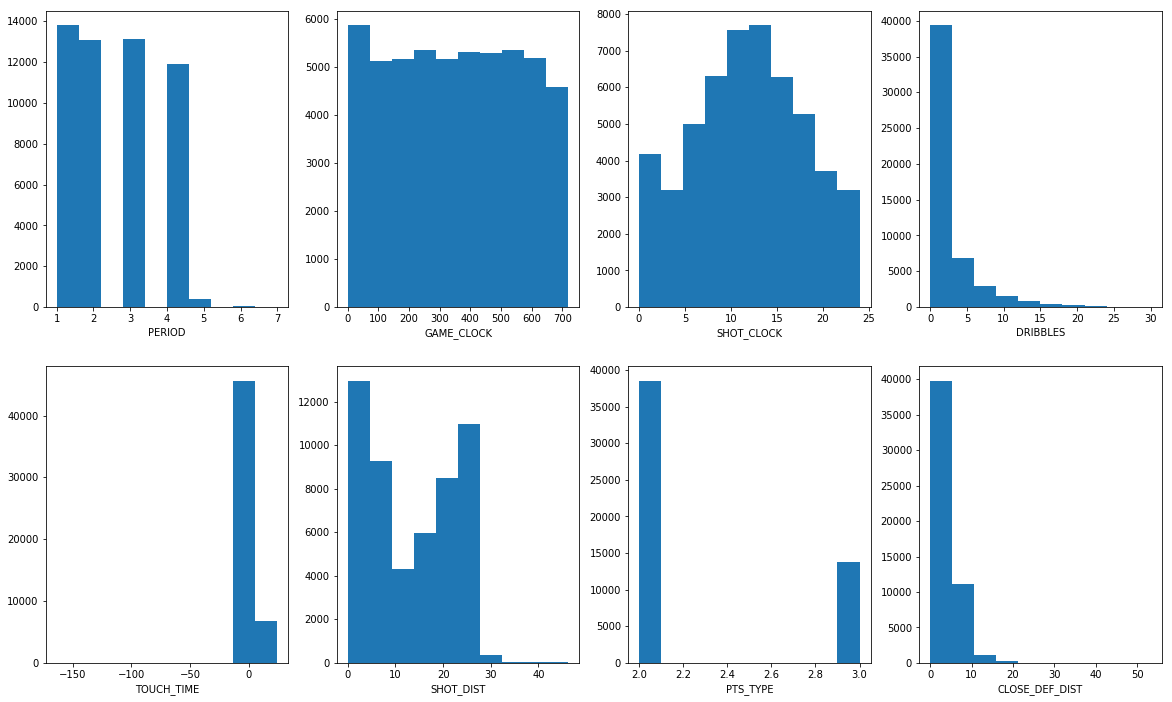

In [24]:
x_vars = ['PERIOD','GAME_CLOCK','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST']
_, subplot_arr = plt.subplots(2, 4, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
    x_idx = idx // 4
    y_idx = idx % 4
    subplot_arr[x_idx, y_idx].hist(X_train[x_var])
    subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

We can tell that some features are very concentrated

In [10]:
def pd2np(df):
    return df.as_matrix()

In [11]:
Xtrain = pd2np(X_train)
Ytrain = pd2np(Y_train)

Xtest = pd2np(X_test)

/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
print(type(Xtrain))
print(Xtrain.shape)

<class 'numpy.ndarray'>
(52399, 8)


### To have a baseline and brief understanding of the dataset, I use whole dataset to train Randomforest to get feature importance reference

In [101]:
r = np.random.permutation(len(Ytrain))
Xtrain = Xtrain[r]
Ytrain = Ytrain[r]

sc_x = StandardScaler()
X_std = sc_x.fit_transform(Xtrain)


In [24]:
np.histogram(Ytrain)

(array([28491,     0,     0,     0,     0,     0,     0,     0,     0,
        23908]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [103]:
#run Linear classifier with with non-std data

clf = linear_model.SGDClassifier(max_iter=10000, n_jobs=-1, random_state=1, eta0=0.01)
clf.fit(X_std, Ytrain)
y_train_pred = clf.predict(X_std)

print('Accuracy train: %2f' % (accuracy_score(Ytrain, y_train_pred)))
print('MSE train: %.2f' %
      (mean_squared_error(Ytrain, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(Ytrain, y_train_pred)))

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy train: 0.595107
MSE train: 0.40
R^2 train: -0.63


In [108]:
#run Random Forest with non-std data

forest = RandomForestClassifier(
    n_estimators=1000, random_state=0, max_depth=30, n_jobs=-1)
forest.fit(Xtrain, Ytrain)
y_train_pred = forest.predict(Xtrain)

print('Accuracy train: %2f' % (accuracy_score(Ytrain, y_train_pred)))
print('MSE train: %.2f' %
      (mean_squared_error(Ytrain, y_train_pred)))
print('R^2 train: %.2f' % (r2_score(Ytrain, y_train_pred)))

/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy train: 0.999981
MSE train: 0.00
R^2 train: 1.00


In [110]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(Xtrain.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            list(X_train)[indices[f]], 
                            importances[indices[f]]))


 1) SHOT_DIST                      0.207485
 2) GAME_CLOCK                     0.197453
 3) SHOT_CLOCK                     0.176788
 4) CLOSE_DEF_DIST                 0.169041
 5) TOUCH_TIME                     0.139914
 6) PERIOD                         0.050979
 7) DRIBBLES                       0.048545
 8) PTS_TYPE                       0.009796


### Here I decided to discard less noise features that are insignificant and over concentrated

## Remove some feature

In [12]:
Xtrain = X_train.drop(['DRIBBLES', 'PTS_TYPE', 'PERIOD'], axis=1) #remove misleading features

In [18]:
Xtrain.head()

,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST
0,557,15.5,2.1,0.0
1,151,20.1,2.7,3.4
2,448,14.2,5.1,0.1
3,279,10.6,1.9,2.7
4,262,10.5,23.9,4.8


In [13]:
Xtrain = pd2np(Xtrain)

/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [14]:
r = np.random.permutation(len(Ytrain))
Xtrain = Xtrain[r]
Ytrain = Ytrain[r]

YTrain = Ytrain.reshape(-1)

sc_x = StandardScaler()
X_std = sc_x.fit_transform(Xtrain)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_std, Ytrain, test_size=0.3, random_state=1)

### normalize dataset and split 30% of data for validation


### Now I start to find the best model I could for the task
first I tried to get best polynomial degree

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


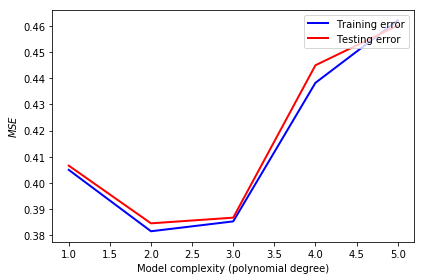

In [8]:
mse_train = []
mse_test = []

max_degree = 6
regr = linear_model.SGDClassifier(max_iter=1000, n_jobs=-1, random_state=1)
    
for d in range(1, max_degree):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(x_train)
    X_test_poly = poly.transform(x_valid)
    
    regr = regr.fit(X_train_poly, y_train)
    y_train_pred = regr.predict(X_train_poly)
    y_test_pred = regr.predict(X_test_poly)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_valid, y_test_pred))
    

plt.plot(range(1, max_degree), mse_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, max_degree), mse_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

It can be easily told that we get lowest MSE when degree = 2 and 3

In [15]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_poly, Ytrain, test_size=0.3, random_state=1)

In [12]:
clf = linear_model.SGDClassifier(max_iter=10000, n_jobs=-1, random_state=1, eta0=0.001)
clf = clf.fit( x_train, y_train)

y_train_pred = clf.predict(x_train)
y_valid_pred = clf.predict(x_valid)

print('Accuracy train: %.3f, validation: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_valid, y_valid_pred)))
print('MSE train: %.2f, validation: %.2f' %
  (mean_squared_error(y_train, y_train_pred),
   mean_squared_error(y_valid, y_valid_pred)))
print('R^2 train: %.2f, validation: %.2f' % (r2_score(y_train, y_train_pred),
                                   r2_score(y_valid, y_valid_pred)))
    


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy train: 0.618, validation: 0.616
MSE train: 0.38, validation: 0.38
R^2 train: -0.54, validation: -0.55


In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(
    Xtrain, Ytrain, test_size=0.3, random_state=1)

forest = RandomForestClassifier(
    n_estimators=1000, random_state=0, max_depth=30, n_jobs=-1)
forest.fit(x_train, y_train)
y_train_pred = forest.predict(x_train)
y_valid_pred = forest.predict(x_valid)

print('Accuracy train: %.3f, validation: %.3f' % (accuracy_score(y_train, y_train_pred),
      accuracy_score(y_valid, y_valid_pred)))
print('MSE train: %.3f, validation: %.3f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_valid, y_valid_pred)))
print('R^2 train: %.3f, validation: %.3f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_valid, y_valid_pred)))

Accuracy train: 1.000, validation: 0.602
MSE train: 0.000, validation: 0.398
R^2 train: 1.000, validation: -0.606


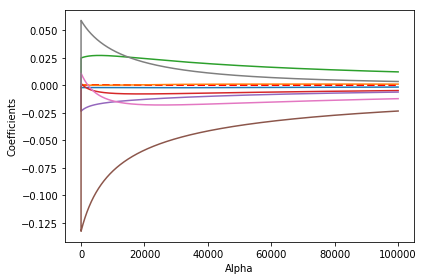

In [23]:
max_alpha = 80000
coef_ = np.zeros((max_alpha, 8))

for a in range(1, max_alpha):
    lr_rg = RidgeClassifier(alpha=a)
    lr_rg.fit(x_train, y_train)

    y_train_pred = lr_rg.predict(x_train)
    y_test_pred = lr_rg.predict(x_valid)
    coef_[a,:] = lr_rg.coef_.reshape(1,-1)
    
plt.hlines(y=0, xmin=0, xmax=max_alpha, color='red', linewidth = 2, linestyle = '--')

for i in range(8):
    plt.plot(range(max_alpha),coef_[:,i])
    
plt.ylabel('Coefficients')
plt.xlabel('Alpha')
plt.tight_layout()
plt.show()

In [18]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_poly, Ytrain, test_size=0.3, random_state=1)


for a in [0, 1, 100, 1000, 10000, 100000, 1000000]:
    lr_rg = RidgeClassifier(alpha=a)
    lr_rg.fit(x_train, y_train)

    y_train_pred = lr_rg.predict(x_train)
    y_valid_pred = lr_rg.predict(x_valid)

    print('\n[Alpha = %d]' % a )
    print('Accuracy train: %.3f, validation: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_valid, y_valid_pred)))
    print('MSE train: %.3f, validation: %.3f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred)))
    print('R^2 train: %.3f, validation: %.3f' % (r2_score(y_train, y_train_pred),
                                   r2_score(y_valid, y_valid_pred)))


[Alpha = 0]
Accuracy train: 0.614, validation: 0.617
MSE train: 0.386, validation: 0.383
R^2 train: -0.555, validation: -0.545

[Alpha = 1]
Accuracy train: 0.614, validation: 0.617
MSE train: 0.386, validation: 0.383
R^2 train: -0.555, validation: -0.545

[Alpha = 100]
Accuracy train: 0.614, validation: 0.617
MSE train: 0.386, validation: 0.383
R^2 train: -0.556, validation: -0.545

[Alpha = 1000]
Accuracy train: 0.614, validation: 0.618
MSE train: 0.386, validation: 0.382
R^2 train: -0.554, validation: -0.541

[Alpha = 10000]
Accuracy train: 0.613, validation: 0.619
MSE train: 0.387, validation: 0.381
R^2 train: -0.559, validation: -0.539

[Alpha = 100000]
Accuracy train: 0.590, validation: 0.590
MSE train: 0.410, validation: 0.410
R^2 train: -0.652, validation: -0.655

[Alpha = 1000000]
Accuracy train: 0.543, validation: 0.547
MSE train: 0.457, validation: 0.453
R^2 train: -0.841, validation: -0.828


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:810: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
from sklearn.linear_model import RidgeClassifier

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_poly, Ytrain, test_size=0.3, random_state=1)


for a in [0, 1, 100, 1000, 10000, 100000, 1000000]:
    lr_rg = RidgeClassifier(alpha=a)
    lr_rg.fit(x_train, y_train)

    y_train_pred = lr_rg.predict(x_train)
    y_valid_pred = lr_rg.predict(x_valid)

    print('\n[Alpha = %d]' % a )
    print('Accuracy train: %.3f, validation: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_valid, y_valid_pred)))
    print('MSE train: %.3f, validation: %.3f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred)))
    print('R^2 train: %.3f, validation: %.3f' % (r2_score(y_train, y_train_pred),
                                   r2_score(y_valid, y_valid_pred)))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:810: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[Alpha = 0]
Accuracy train: 0.617, validation: 0.620
MSE train: 0.383, validation: 0.380
R^2 train: -0.544, validation: -0.532

[Alpha = 1]
Accuracy train: 0.617, validation: 0.620
MSE train: 0.383, validation: 0.380
R^2 train: -0.544, validation: -0.531

[Alpha = 100]
Accuracy train: 0.617, validation: 0.621
MSE train: 0.383, validation: 0.379
R^2 train: -0.542, validation: -0.531

[Alpha = 1000]
Accuracy train: 0.617, validation: 0.621
MSE train: 0.383, validation: 0.379
R^2 train: -0.542, validation: -0.528

[Alpha = 10000]
Accuracy train: 0.617, validation: 0.622
MSE train: 0.383, validation: 0.378
R^2 train: -0.542, validation: -0.527

[Alpha = 100000]
Accuracy train: 0.614, validation: 0.616
MSE train: 0.386, validation: 0.384
R^2 train: -0.555, validation: -0.548

[Alpha = 1000000]
Accuracy train: 0.562, validation: 0.565
MSE train: 0.438, validation: 0.435
R^2 train: -0.763, validation: -0.756


### The best model I've got is RidgeClassifier with degree = 3 and alpha=10000
### Let's plot the learning curve of it

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


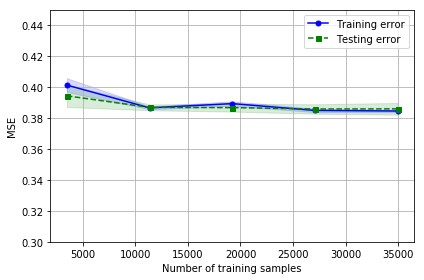

In [19]:
from sklearn.learning_curve import learning_curve

def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

Ytrain = Ytrain.reshape(-1)

lr_rg = RidgeClassifier(alpha=10000)
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_rg, X=X_poly, y=Ytrain, scoring=mse)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5,
    label='Training error')
plt.fill_between(train_sizes,
    train_mean+train_std,
    train_mean-train_std,
    alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Testing error')
plt.fill_between(train_sizes,
    test_mean+test_std,
    test_mean-test_std,
    alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.ylim([0.3, 0.45])
plt.tight_layout()
plt.show()

In [20]:
Xtest = X_test.drop(['DRIBBLES', 'PTS_TYPE', 'PERIOD'], axis=1)
Xtest.head()

,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
0,220,13.3,10.1,18.5,10.5
1,2,0.0,1.3,25.1,5.8
2,375,22.1,2.7,5.2,1.6
3,597,15.2,8.6,8.1,3.3
4,48,2.1,2.5,3.2,2.7


In [21]:
from sklearn.linear_model import RidgeClassifier

sc_x = StandardScaler()
X_std = sc_x.fit_transform(Xtrain)
X_std_test = sc_x.fit_transform(Xtest)

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)
X_poly_test = poly.transform(X_std_test)

lr_rg = RidgeClassifier(alpha=1)
lr_rg.fit(X_poly, Ytrain)

y_train_pred = lr_rg.predict(X_poly)
y_test_pred = lr_rg.predict(X_poly_test)

print('\n[Alpha = %d]' % a )
print('Accuracy train: %.3f' % (accuracy_score(Ytrain, y_train_pred)))
print('MSE train: %.3f' % (mean_squared_error(Ytrain, y_train_pred)))
print('R^2 train: %.3f' % (r2_score(Ytrain, y_train_pred)))
 
df = pd.DataFrame(y_test_pred)
df.to_csv("y_pred.csv")


[Alpha = 1000000]
Accuracy train: 0.619
MSE train: 0.381
R^2 train: -0.538


# select 3 features

### I chose top 3 feature in my random forest test

In [29]:
Xtrain = X_train.drop(['DRIBBLES', 'CLOSE_DEF_DIST', 'PTS_TYPE', 'PERIOD','TOUCH_TIME'], axis=1) 

In [30]:
Xtrain = pd2np(Xtrain)

r = np.random.permutation(len(Ytrain))
Xtrain = Xtrain[r]
Ytrain = Ytrain[r]

sc_x = StandardScaler()
X_std = sc_x.fit_transform(Xtrain)

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_std)

x_train, x_valid, y_train, y_valid = train_test_split(
    X_poly, Ytrain, test_size=0.3, random_state=1)

/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [31]:
for a in [0, 1, 100, 1000, 10000, 100000]:
    lr_rg = RidgeClassifier(alpha=a)
    lr_rg.fit(x_train, y_train)

    y_train_pred = lr_rg.predict(x_train)
    y_valid_pred = lr_rg.predict(x_valid)

    print('\n[Alpha = %d]' % a )
    print('Accuracy train: %.3f, validation: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_valid, y_valid_pred)))
    print('MSE train: %.3f, validation: %.3f' % (
                    mean_squared_error(y_train, y_train_pred),
                    mean_squared_error(y_valid, y_valid_pred)))
    print('R^2 train: %.3f, validation: %.3f' % (r2_score(y_train, y_train_pred),
                                   r2_score(y_valid, y_valid_pred)))


[Alpha = 0]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846

[Alpha = 1]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846

[Alpha = 100]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846

[Alpha = 1000]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846

[Alpha = 10000]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846

[Alpha = 100000]
Accuracy train: 0.545, validation: 0.542
MSE train: 0.455, validation: 0.458
R^2 train: -0.836, validation: -0.846
